# How reproducible is the width of the bump on multiple runs

In [3]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [3]:
#Defining Parameters
Num_runs   = 100
BETA = 1
beta = np.zeros(Num_runs) + BETA
Num_configs = 10000

Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
#N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size

N = np.zeros(Num_runs) + 100

#print beta
#print N

for i in np.arange(len(N)):
    N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

In [ ]:
%%capture capt1
#Supress the output of the cell and save it to capt1

BM      = []
data    = []
results = []
RBM     = []

for i in np.arange(len(beta)):
    #Generate spins using Gibbs Sampling MCMC
    BM.append(bm.BM(N=N[i],nature='Spin'))

    #Define Couplings
    BM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
    BM[i].layer.couplings[0,-1] += beta[i]
    BM[i].layer.couplings[-1,0] += beta[i]
    
    #Generating the ising model data
    data.append(BM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

    #Train the model
    RBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
    results.append(RBM[i].fit(data[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))

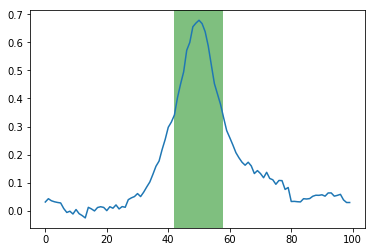

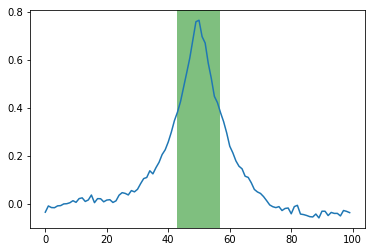

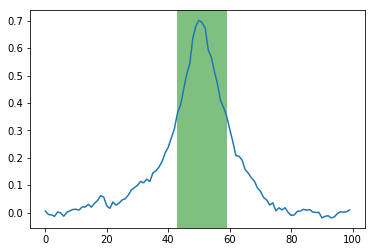

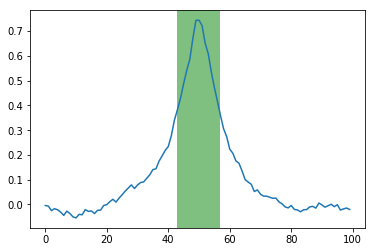

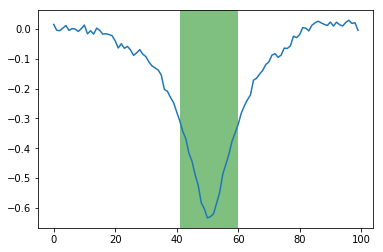

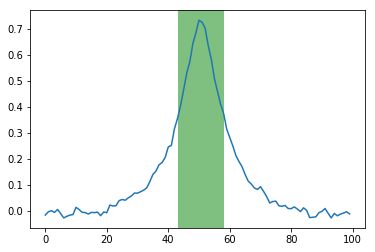

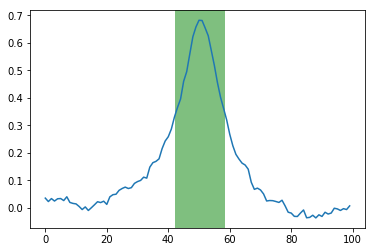

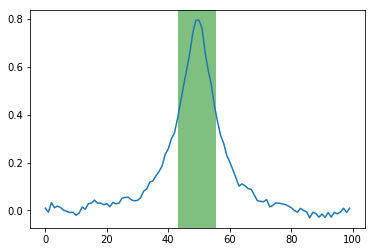

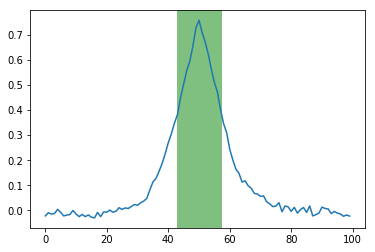

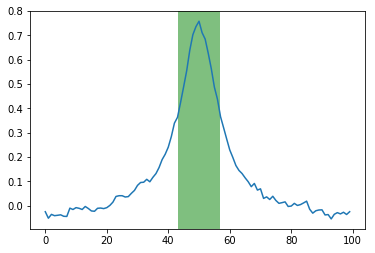

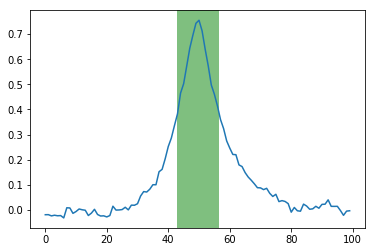

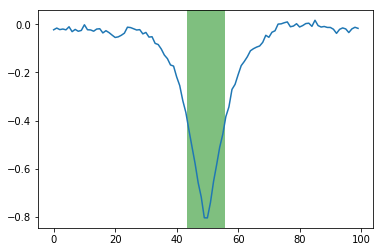

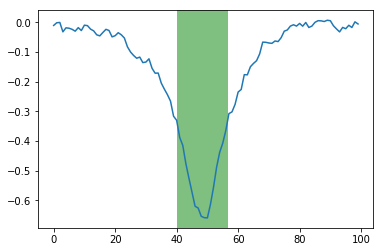

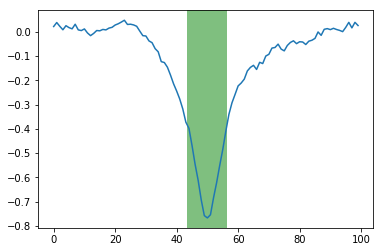

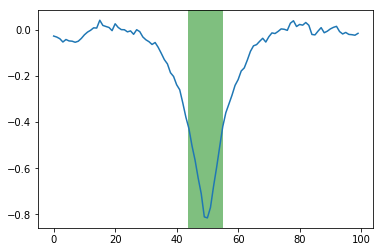

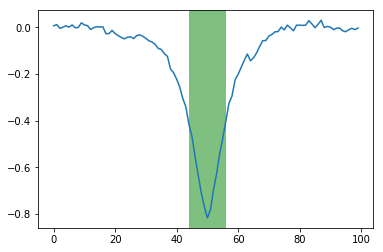

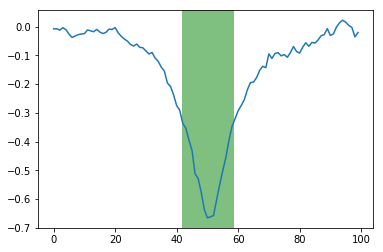

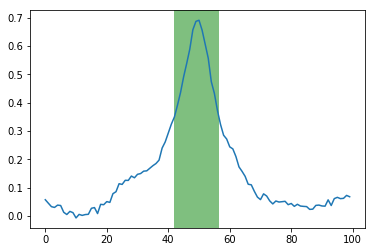

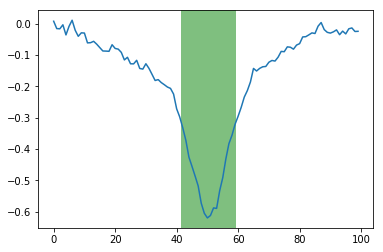

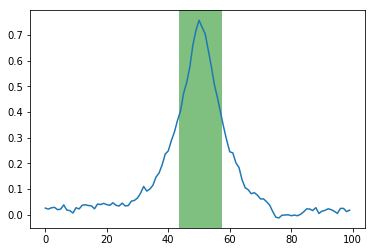

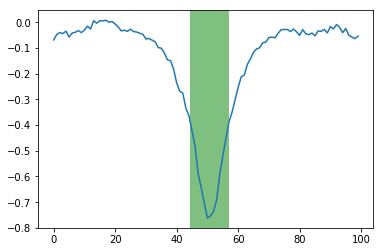

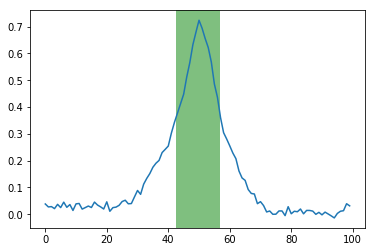

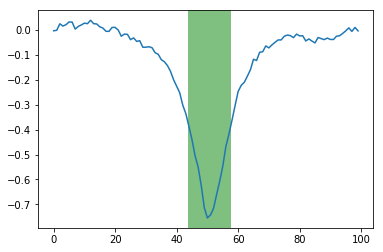

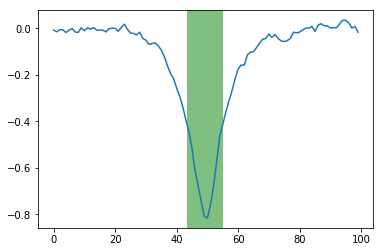

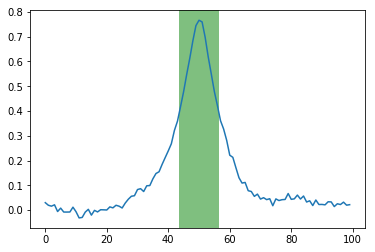

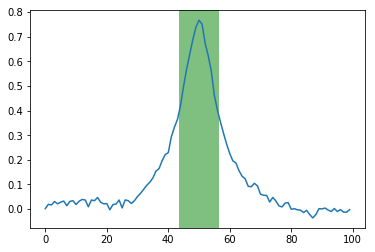

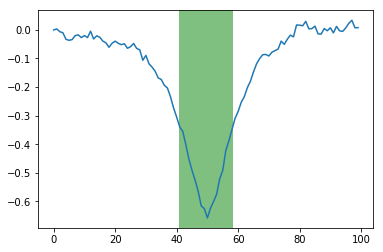

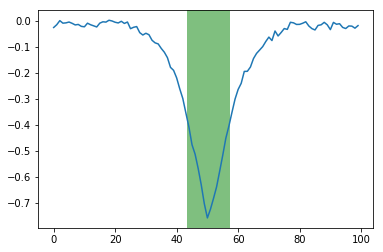

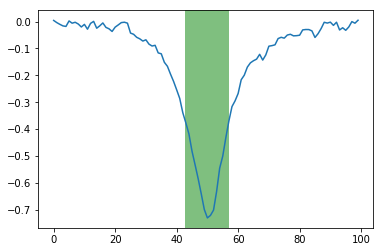

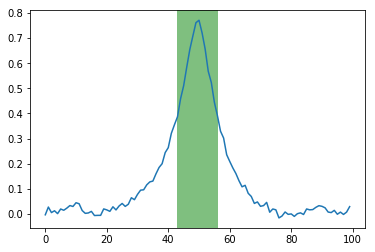

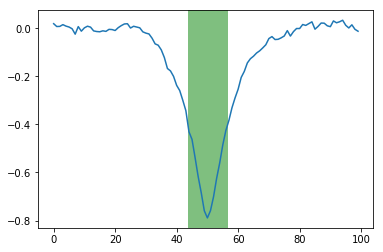

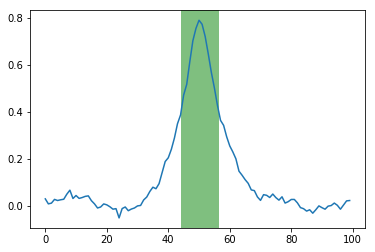

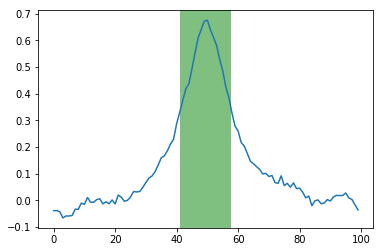

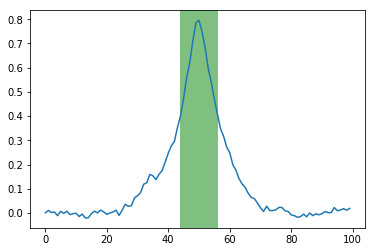

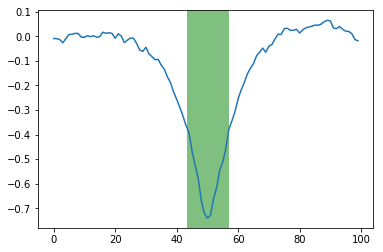

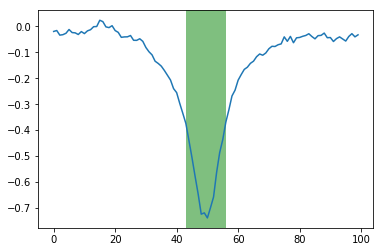

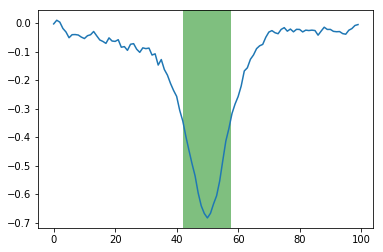

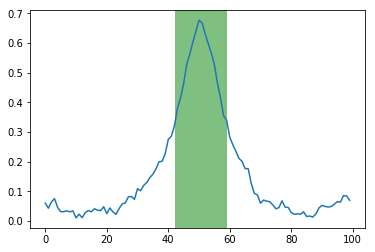

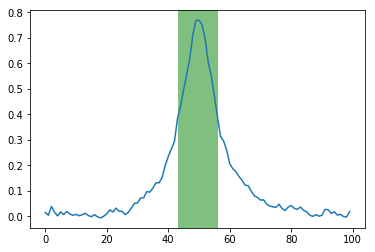

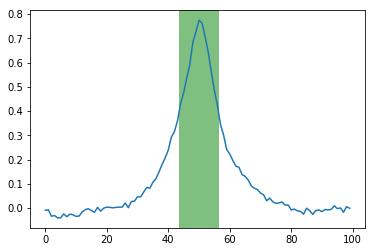

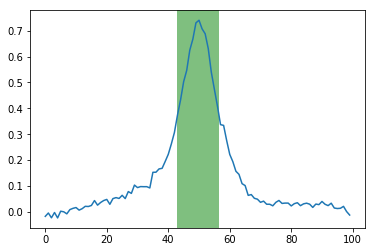

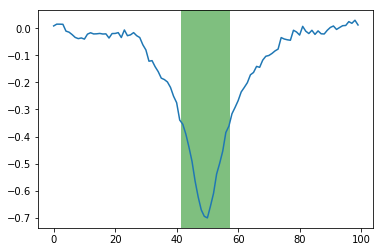

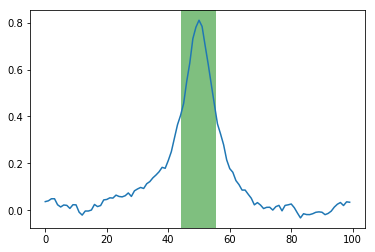

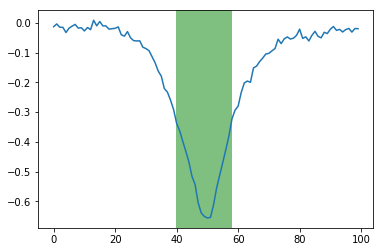

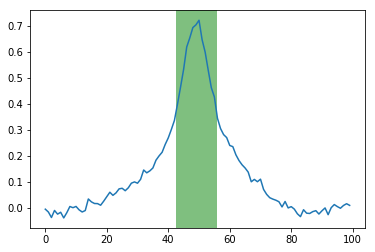

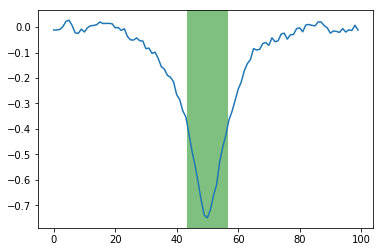

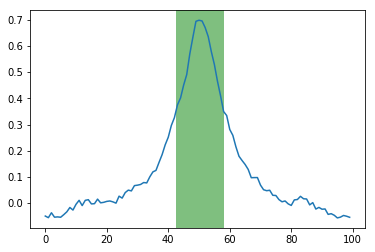

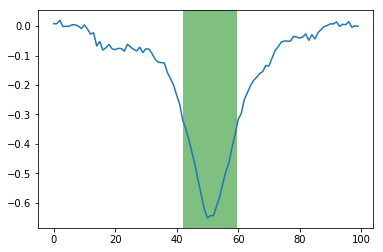

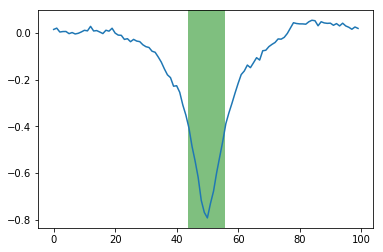

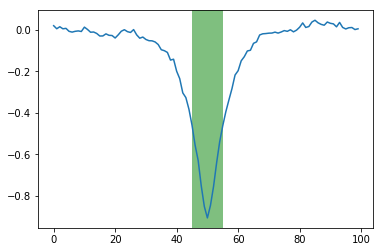

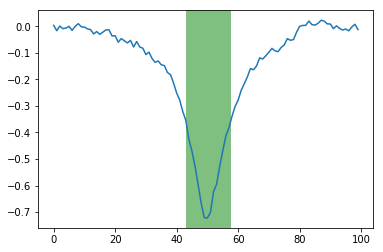

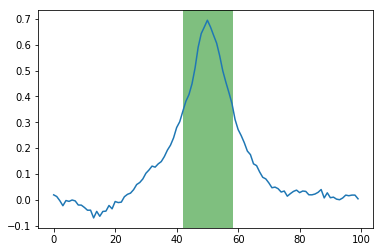

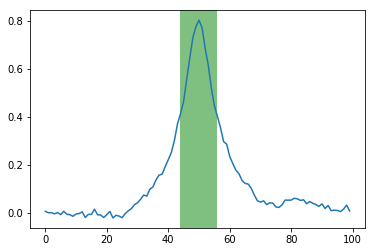

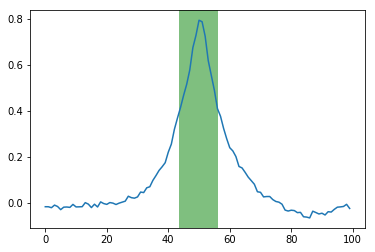

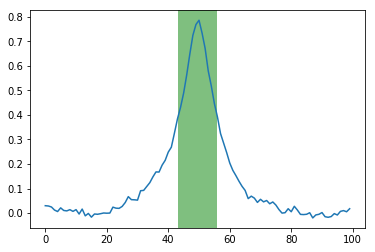

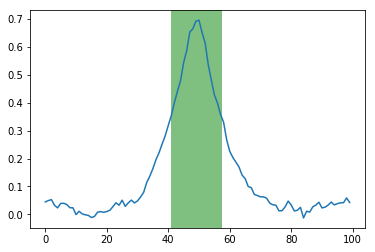

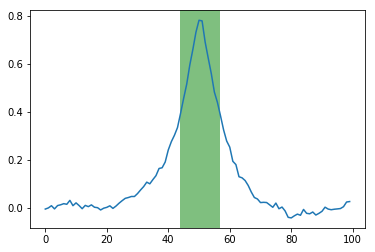

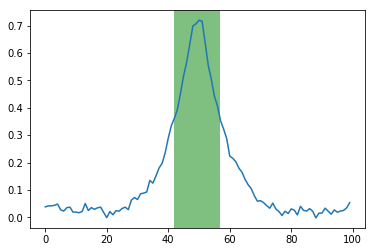

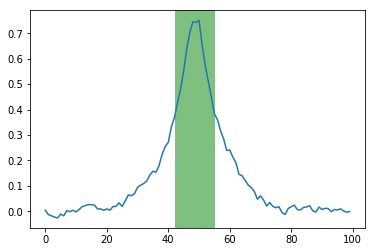

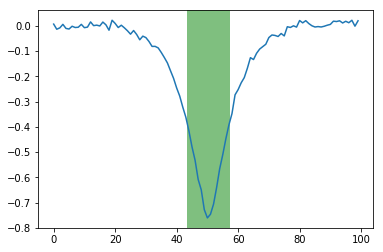

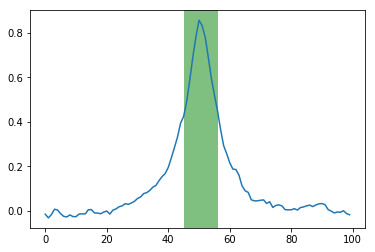

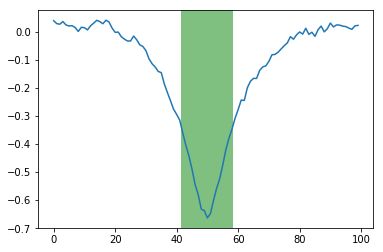

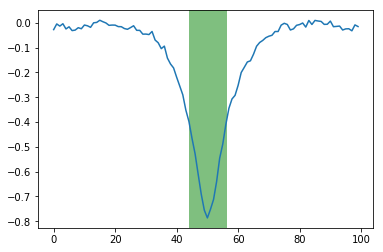

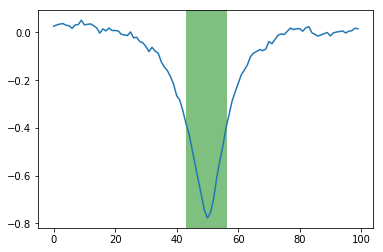

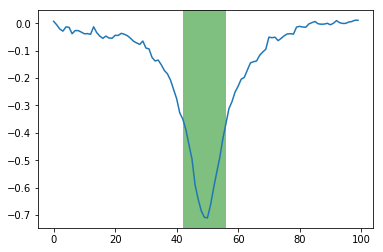

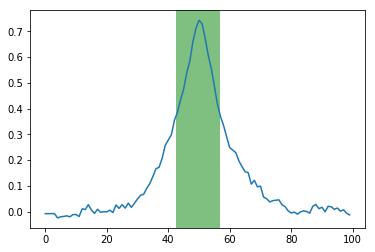

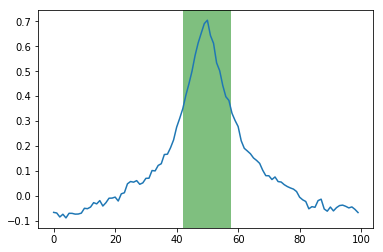

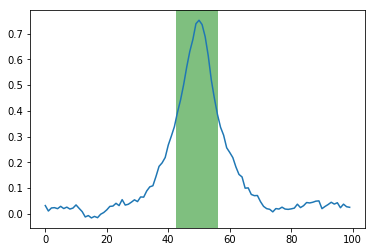

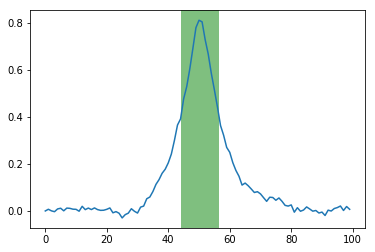

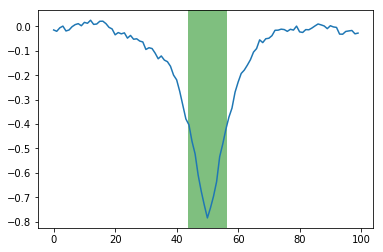

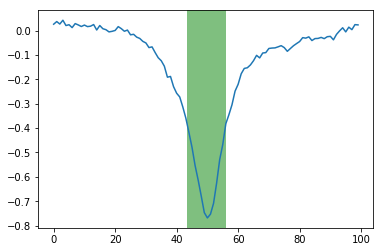

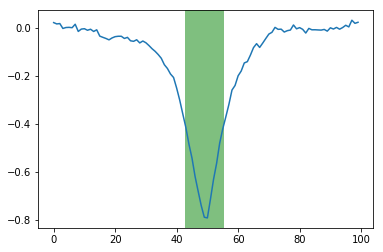

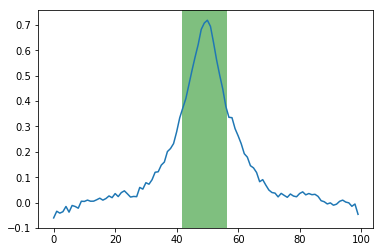

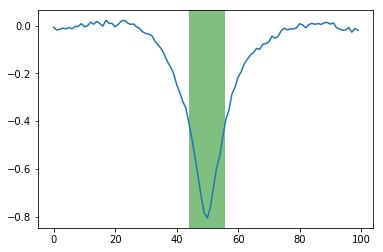

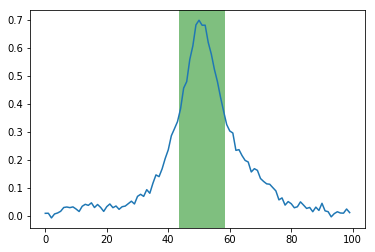

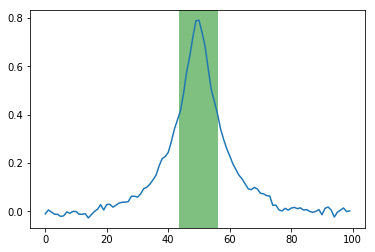

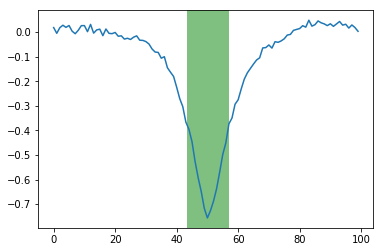

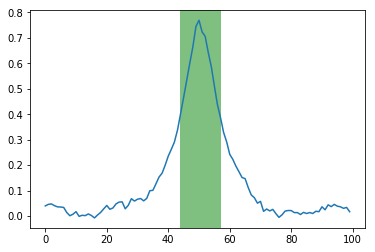

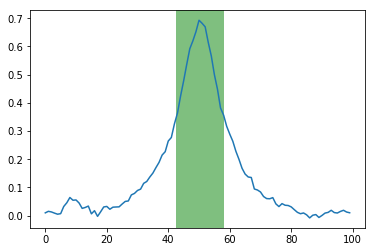

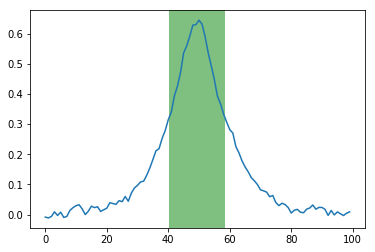

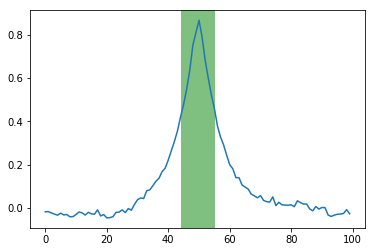

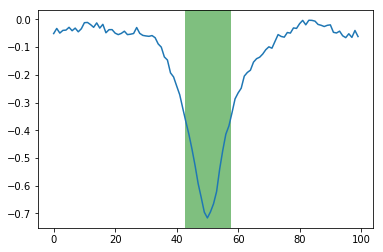

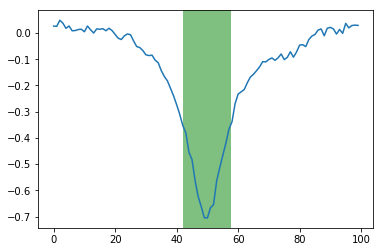

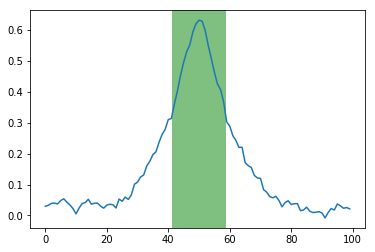

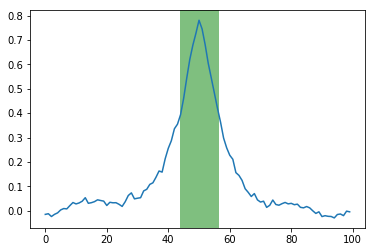

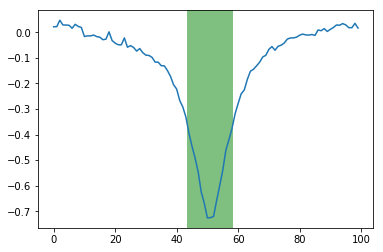

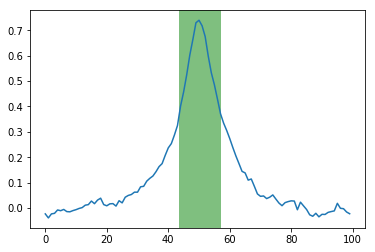

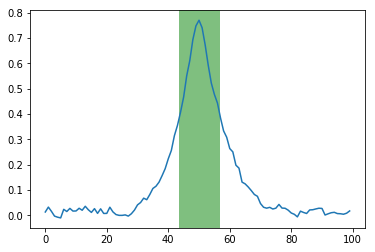

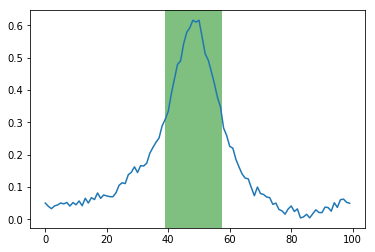

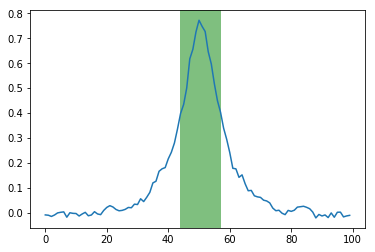

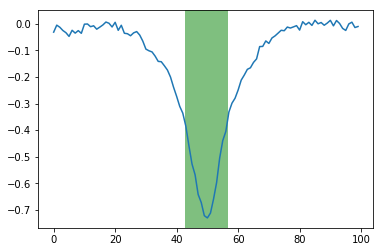

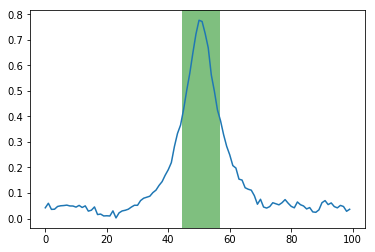

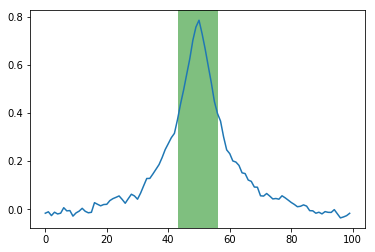

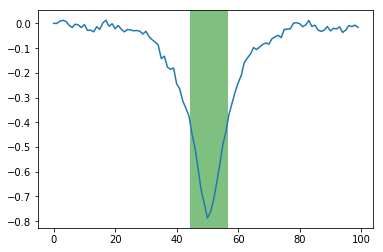

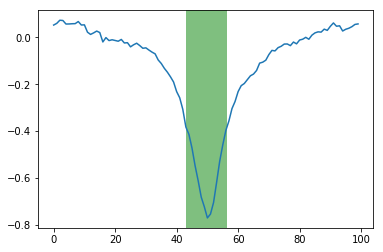

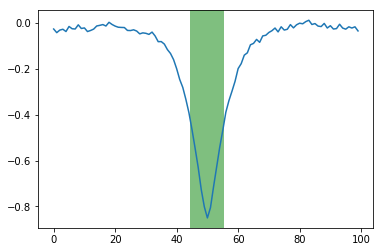

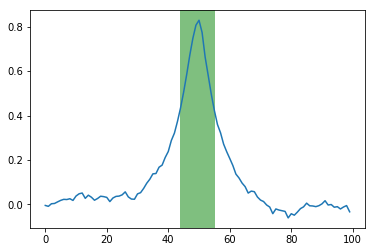

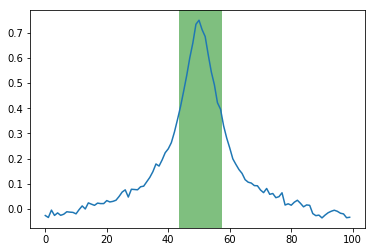

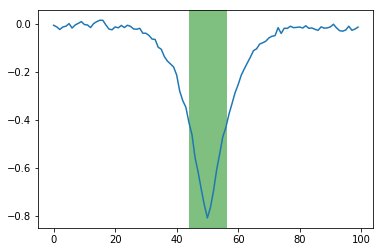

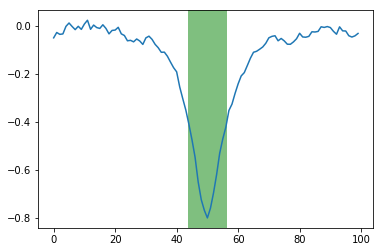

[15.895656644816356, 13.954476176620084, 16.259976527823007, 14.063516171624677, 18.863775278277572, 14.868095339975035, 16.230310468675057, 12.39688186656047, 14.421320923507004, 13.476832903658966, 13.711573175463641, 12.200615135926434, 16.559325987089913, 12.929114017842821, 11.535164859313447, 12.03540051484493, 16.608694246230648, 14.631388853293309, 17.983650695845952, 13.991093038960791, 12.835347810339911, 14.421093952532594, 13.942409615033405, 11.814643626381915, 13.15128805666734, 12.971239337483276, 17.824499374156076, 14.04413193914997, 14.426016091041582, 13.106322707704869, 13.175652286370159, 12.331293453949264, 16.646545973219069, 12.244335293134299, 13.810037765160672, 13.104666257772365, 15.57081995763513, 16.718244910222978, 13.056834660190027, 13.043110266968235, 13.514463551032428, 15.787109011036954, 11.500656691628841, 18.150376506259292, 13.363185326122377, 13.411198992549252, 15.552302342440704, 17.676633375874367, 12.032817848806133, 10.216768100158731, 14.4

(array([  2.,   7.,  18.,  26.,  16.,   7.,   9.,   7.,   4.,   4.]),
 array([ 10.2167681 ,  11.08146882,  11.94616954,  12.81087025,
         13.67557097,  14.54027169,  15.40497241,  16.26967312,
         17.13437384,  17.99907456,  18.86377528]),
 <a list of 10 Patch objects>)

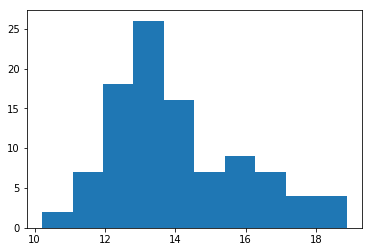

In [8]:
# Fitting the Peak and calculating the width

from scipy.interpolate import UnivariateSpline
import pylab as pl

#Roll the array to put the peak in the centre
weightsAligned = []
spline = []
roots  = []
FWHM   = []

#for i in np.arange(len(beta)):
for i in np.arange(len(beta)):
    roll_val = -(np.argmax(abs(np.array(results[i]['W'])[-1,0,:])) - int(len(np.array(results[i]['W'])[-1,0,:])/2))
    weightsAligned.append(np.roll(np.array(results[i]['W'])[-1,0,:],roll_val))
    spline.append(UnivariateSpline(np.arange(len(np.array(results[i]['W'])[-1,0,:])),abs(weightsAligned[i])-np.max(abs(weightsAligned[i]))/2,s=0))
    roots.append(spline[i].roots())
    
    #Show the roots for visual verification
    pl.plot(np.arange(len(np.array(results[i]['W'])[-1,0,:])),weightsAligned[i])
    pl.axvspan(roots[i][0], roots[i][1], facecolor='g', alpha=0.5)
    pl.show()
    #I = input("Press Enter to continue...")
    
    FWHM.append(abs(roots[i][0]-roots[i][1]))
    
print FWHM

plt.hist(FWHM)

(array([ 0.02312939,  0.08095286,  0.20816451,  0.30068207,  0.18503512,
         0.08095286,  0.10408225,  0.08095286,  0.04625878,  0.04625878]),
 array([ 10.2167681 ,  11.08146882,  11.94616954,  12.81087025,
         13.67557097,  14.54027169,  15.40497241,  16.26967312,
         17.13437384,  17.99907456,  18.86377528]),
 <a list of 10 Patch objects>)

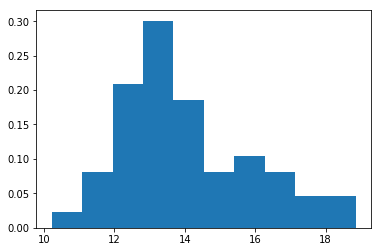

In [10]:
plt.hist(FWHM,density=True,stacked=True)

## Check how does the peak width distrubute in time for only one run

(array([  12.,   43.,   97.,  149.,  112.,   45.,   25.,   13.,    1.,    3.]),
 array([ 13.08325067,  13.23404096,  13.38483125,  13.53562154,
         13.68641183,  13.83720211,  13.9879924 ,  14.13878269,
         14.28957298,  14.44036327,  14.59115356]),
 <a list of 10 Patch objects>)

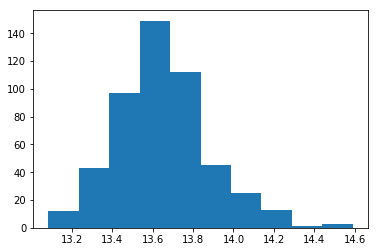

In [15]:
# Fitting the Peak and calculating the width

from scipy.interpolate import UnivariateSpline
import pylab as pl

#Roll the array to put the peak in the centre
weightsAligned1 = []
spline1 = []
roots1  = []
FWHM1   = []

#for i in np.arange(len(beta)):
for i in np.arange(500):
    roll_val = -(np.argmax(abs(np.array(results[-10]['W'])[-(500-i),0,:])) - int(len(np.array(results[-10]['W'])[-(500-i),0,:])/2))
    weightsAligned1.append(np.roll(np.array(results[-10]['W'])[-(500-i),0,:],roll_val))
    spline1.append(UnivariateSpline(np.arange(len(np.array(results[-10]['W'])[-(500-i),0,:])),abs(weightsAligned1[i])-np.max(abs(weightsAligned1[i]))/2,s=0))
    roots1.append(spline1[i].roots())
    
    #Show the roots for visual verification
    #pl.plot(np.arange(len(np.array(results[-1]['W'])[-1,0,:])),weightsAligned[i])
    #pl.axvspan(roots[i][0], roots[i][1], facecolor='g', alpha=0.5)
    #pl.show()
    #I = input("Press Enter to continue...")
    
    FWHM1.append(abs(roots1[i][0]-roots1[i][1]))
    
#print FWHM1

plt.hist(FWHM1)

## Does increasing the batch size reduce the noise in the width?

In [4]:
#Defining Parameters
Num_runs   = 100
BETA = 1
beta = np.zeros(Num_runs) + BETA
Num_configs = 10000

Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
#N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size

N = np.zeros(Num_runs) + 100

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

In [ ]:
%%capture capt2
#Supress the output of the cell and save it to capt2

BM2      = []
data2    = []
results2 = []
RBM2     = []

for i in np.arange(len(beta)):
    #Generate spins using Gibbs Sampling MCMC
    BM2.append(bm.BM(N=N[i],nature='Spin'))

    #Define Couplings
    BM2[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
    BM2[i].layer.couplings[0,-1] += beta[i]
    BM2[i].layer.couplings[-1,0] += beta[i]
    
    #Generating the ising model data
    data2.append(BM2[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

    #Train the model
    RBM2.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
    results2.append(RBM2[i].fit(data2[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False))

(array([  1.,   9.,  22.,  22.,  17.,  11.,   8.,   4.,   2.,   1.]),
 array([ 10. ,  11.5,  13. ,  14.5,  16. ,  17.5,  19. ,  20.5,  22. ,
         23.5,  25. ]),
 <a list of 10 Patch objects>)

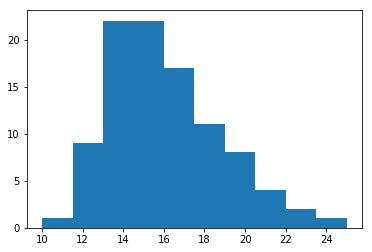

In [16]:
import peakWidth

PW = []
for i in range(len(beta)):
    PW.append(peakWidth.peakWidth(weight = np.array(results2[i]['W'])[-1,0,:]))
    
plt.hist(PW,range=(10,25))

In [17]:
print np.array(results2[i]['W']).shape

(250, 1, 100)


In [ ]:
inlineMovies.inlineMovies()